In [1]:
%matplotlib inline

import numpy
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
# from rootpy.io import root_open
from sklearn.neighbors import BallTree, DistanceMetric

mpl.rc('font', size=15)

In [2]:
# convert ROOT histogram into numpy arrays
def convert_to_array(hist):
    n = hist.GetNbinsX()   # number of bins
    axis = hist.GetXaxis() 
    
    # output
    bins = np.empty(n+1)
    entries = np.empty(n)
    for i in xrange(n):
        entries[i] = hist.GetBinContent(i+1)
        bins[i] = axis.GetBinLowEdge(i+1)
    bins[i+1] = axis.GetBinUpEdge(n)
    
    return entries, bins

# Import data 

In [3]:
# import data
catalog_dir = "/home/chris/project/bao/correlation/catalog/"
random_filename = catalog_dir+"boss/randoms_DR9_CMASS_North_DC.dat"

ra, dec, r, weight = np.genfromtxt(random_filename, skip_header=1, unpack=True)

# Construct RR
## Defing binning

In [4]:
# define constant
degtorad = np.pi/180.
radtodeg = 180./np.pi

n = len(ra)

# define binning 
s_max = 200.   # Mpc/h
theta_max = np.arccos(1-0.5*s_max**2/r.min()**2) # in rad
binwidth_ra = 0.25 # deg
binwidth_dec = 0.25  # deg
binwidth_theta = 0.1  # deg
binwidth_r = 1.00   # Mpc/h
binwidth_s = 4.0   # Mpc/h
nbin_ra = int(np.ceil((ra.max()-ra.min())/binwidth_ra))
nbin_dec = int(np.ceil((dec.max()-dec.min())/binwidth_dec))
nbin_theta = int(np.ceil(theta_max/(degtorad*binwidth_theta)))
nbin_r = int(np.ceil((r.max()-r.min())/binwidth_r))
nbin_s = int(np.ceil((s_max)/binwidth_s))

## Construct P(r)

In [15]:
# construct RR(s)
# construct P(r)
r_hist, bins_r = np.histogram(r, nbin_r)

r_hist = 1.*r_hist/n

## Construct f(theta)

In [6]:
def histogram2points(hist, bins_x, bins_y, exclude_zeros=True):
    ''' Convert 2-d histogram into data points with weight.
        Take bincenters as data points.
        Parameters:
        + hist:  2-d numpy array
            The values of of the histogram.
            Dimension must be [Nx, Ny], the number of bins in X and Y
        + bins_x:  numpy array
            Binedges in X, length must be Nx+1
        + bins_y:  numpy array
            Binedges in Y, length must be Nx+1
        + exclude_zeros: bool (default = True)
            Excluded zeros bins
        Outputs:
        + data: 2-d numpy array
            Array of data points with weight. Format [X,Y,Weight]
        '''
    center_x = 0.5*(bins_x[:-1]+bins_x[1:])
    center_y = 0.5*(bins_y[:-1]+bins_y[1:])
    grid_x, grid_y = numpy.meshgrid(center_x, center_y)
    grid_x = grid_x.flatten()
    grid_y = grid_y.flatten()
    hist = hist.T.flatten()

    # Create data array with non-zero bins
    data = numpy.array([grid_x, grid_y, hist]).T
    if exclude_zeros:
        return data[hist > 0]
    return data

In [7]:
a = histogram2points(*np.histogram2d(dec, ra, (nbin_dec, nbin_ra)))

In [8]:
nbin_dec,nbin_ra

(240, 620)

In [9]:
# construct R(ra, dec)
angular_counts, ra_edges, dec_edges = np.histogram2d(ra, dec, (nbin_ra, nbin_dec))
angular_counts = angular_counts.T

# generate data set with weight
ra_centers = 0.5*(ra_edges[:-1]+ra_edges[1:])
dec_centers = 0.5*(dec_edges[:-1]+dec_edges[1:])
ra_grid, dec_grid = np.meshgrid(ra_centers, dec_centers)
ra_grid = ra_grid.flatten()
dec_grid = dec_grid.flatten()
angular_counts = angular_counts.flatten()

data = np.array([degtorad*dec_grid, degtorad*ra_grid, angular_counts]).T
data = data[angular_counts>0]

# create Tree
arc_tree = BallTree(data[:,:2], leaf_size=1, metric='haversine')

In [10]:
# compute f(theta)
bins_theta = np.linspace(0., theta_max, nbin_theta+1)
theta_hist = np.zeros(nbin_theta)
for i, point in enumerate(data):
    if i%10000 is 0:
        print i
    index, theta = arc_tree.query_radius(point[:2].reshape(1,-1), r=theta_max, return_distance=True)
    index = index[0]
    theta = theta[0]
    temp_weight = point[2]*data[:,2][index]
    temp_hist, _ = np.histogram(theta, bins=bins_theta, weights=temp_weight)
    theta_hist += temp_hist
    
theta_hist = theta_hist/2.

0
10000
20000
30000
40000
50000


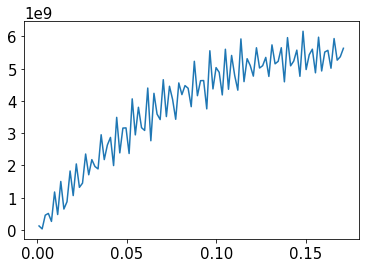

In [11]:
x = 0.5*(bins_theta[:-1]+bins_theta [1:])
plt.plot(x, theta_hist)
# plt.plot(x, theta_root)

## Construct RR

In [16]:
def separation(r1, r2, theta):
    return np.sqrt(r1**2+r2**2-2*r1*r2*np.cos(theta))

In [17]:
r_centers = 0.5*(bins_r[1:]+bins_r[:-1])
theta_centers = 0.5*(bins_theta[1:]+bins_theta[:-1])

In [18]:
w = np.zeros((theta_centers.size, r_centers.size))
for i in xrange(theta_centers.size):
    for j in xrange(r_centers.size):
        w[i,j] = theta_hist[i]*r_hist[j]
w = w.flatten()

a, b = np.meshgrid(r_centers, theta_centers)
a = a.flatten()
b = b.flatten()

c = np.array([a,b,w]).T
c = c[w!=0]

In [19]:
weight = numpy.zeros((theta_hist.size, r_hist.size))
for i in range(theta_hist.size):
    for j in range(r_hist.size):
        weight[i, j] = theta_hist[i]*r_hist[j]
temp = histogram2points(weight, bins_theta, bins_r)
print(temp)

centers_r = 0.5*(bins_r[:-1]+bins_r[1:])
rand_rand = numpy.zeros(50)
for i, temp_r in enumerate(centers_r[r_hist != 0]):
    if i % 100 is 0:
        print(i)
    temp_s = separation(temp_r, temp[:, 1], temp[:, 0])
    temp_weight = r_hist[i]*temp[:, 2]
    temp_hist, bins_s = numpy.histogram(temp_s, 50,
                                        range=(0, 200),
                                        weights=temp_weight)
    rand_rand += temp_hist

[[  8.67786671e-04   1.16592990e+03   6.88159097e+04]
 [  2.60336001e-03   1.16592990e+03   1.86400320e+04]
 [  4.33893335e-03   1.16592990e+03   2.51226781e+05]
 ..., 
 [  1.67482827e-01   1.77281010e+03   2.66271088e+06]
 [  1.69218401e-01   1.77281010e+03   2.71652152e+06]
 [  1.70953974e-01   1.77281010e+03   2.84862282e+06]]
0
100
200
300
400
500
600


In [20]:
bins_s = np.linspace(0., s_max, nbin_s+1)
rr = np.zeros(nbin_s)
for i, rtemp in enumerate(r_centers[radial_hist_uw!=0]):
    if i%100 is 0:
        print i
    s = separation(rtemp, c[:,0], c[:,1])
    temp_hist, _ = np.histogram(s, bins_s, weights = radial_hist_uw[i]*c[:,2])
    rr += temp_hist

0
100
200
300
400
500
600


In [21]:
# normalize
# unweighted
norm_rr_uw = n*(n-1)/2
rr_norm = rr/norm_rr_uw
rr_test = rand_rand/norm_rr_uw

In [22]:
from rootpy.io import root_open

root_filename = "/home/chris/project/bao/correlation/tpcf/out/BOSS_North.root"

#import ROOT histogram and convert to NumPy array
rootfile = root_open(root_filename, "read")
rr_root, bins_root = convert_to_array(rootfile.Get("Unweighted").Get("rand_rand_uw"))
dd_root, _ = convert_to_array(rootfile.Get("Unweighted").Get("data_data_uw"))

Welcome to JupyROOT 6.08/06


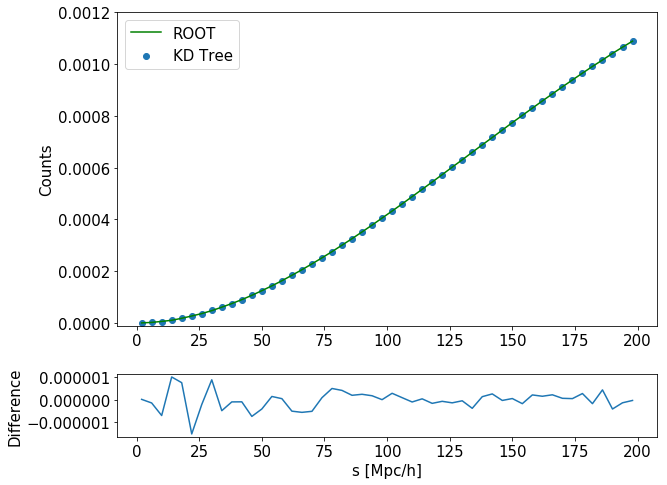

In [28]:
fig = plt.figure(figsize=(12,7))
gs  = gridspec.GridSpec(2, 2, width_ratios=[10,3], height_ratios=[10,2])
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[2], sharex = ax1)

# plot two histograms on top of each other
x = 0.5*(bins_s[:-1]+bins_s[1:])
ax1.scatter(x, rr_test, label = 'KD Tree')
ax1.plot(x, rr_root, color = 'g', label = 'ROOT')
ax1.set(ylim = [-0.00001,0.0012],
        ylabel='Counts')

ax2.plot(x, rr_norm-rr_root)
ax2.set(xlabel='s [Mpc/h]',
        ylabel='Difference')

ax1.legend()
fig.tight_layout()

## Save result

In [ ]:
np.savez("rr", RR=rr_norm, BINS=bins_s)

In [ ]:
f = np.load("test/rr.npz")
rr_test = f['RR']

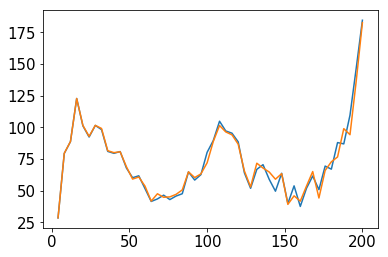

In [282]:
tpcf = x**2*(dd_norm/rr_norm-1)
tpcf_root = x**2*(dd_root/rr_root-1)
plt.plot(bins_s[1:], tpcf)
plt.plot(bins_s[1:], tpcf_root)